In [1]:
from datetime import datetime
from datetime import timedelta

import pandas
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

In [2]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["month"]
del df["day"]
del df["year"]
del df["post_month"]
df

,days_since_previous_release,release_post,date
id,,,
50,NaN,False,2016-02-15
123,NaN,False,2016-02-15
173,NaN,False,2016-02-15
156,NaN,False,2016-02-15
133,NaN,False,2016-02-15
...,...,...,...
271,5.0,True,2021-01-11
272,7.0,True,2021-01-18
273,7.0,True,2021-01-25


In [3]:
df.query("release_post == True & days_since_previous_release.isnull()")

,days_since_previous_release,release_post,date
id,,,


In [4]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [5]:
filled_in = [dict(df.iloc[0])]
# df should already be sorted by date
current_date = filled_in[0]["date"]
days_since_release = filled_in[0]["days_since_previous_release"] # should be 0
while current_date < df.iloc[-1]["date"]:
    days_since_release += 1
    current_date = current_date + timedelta(days=1)
    in_df = df[df["date"] == current_date]
    if len(in_df) == 1:
        filled_in.append({"date" : current_date, "release_post" : in_df.iloc[0]["release_post"],
                          "days_since_previous_release" : days_since_release})
        days_since_release = 0
    else:
        filled_in.append({"date" : current_date, "release_post" : False,
                          "days_since_previous_release" : days_since_release})
        
features_df = pandas.DataFrame(filled_in)
features_df

,days_since_previous_release,release_post,date
0,0.0,True,2017-02-17
1,1.0,False,2017-02-18
2,2.0,False,2017-02-19
3,3.0,False,2017-02-20
4,4.0,False,2017-02-21
...,...,...,...
1446,3.0,False,2021-02-02
1447,4.0,False,2021-02-03
1448,5.0,False,2021-02-04
1449,6.0,False,2021-02-05


In [6]:
features_df["release_post"].value_counts()

False    1266
True      185
Name: release_post, dtype: int64

In [7]:
features_df["weekday"] = features_df["date"].apply(lambda x : x.weekday())
features_df["month"] = features_df["date"].apply(lambda x : x.month)
features_df

,days_since_previous_release,release_post,date,weekday,month
0,0.0,True,2017-02-17,4,2
1,1.0,False,2017-02-18,5,2
2,2.0,False,2017-02-19,6,2
3,3.0,False,2017-02-20,0,2
4,4.0,False,2017-02-21,1,2
...,...,...,...,...,...
1446,3.0,False,2021-02-02,1,2
1447,4.0,False,2021-02-03,2,2
1448,5.0,False,2021-02-04,3,2
1449,6.0,False,2021-02-05,4,2


In [8]:
false_df = features_df[features_df["release_post"] == False].sample(
    n=len(features_df[features_df["release_post"] == True]), random_state=1024)
len(false_df)

185

In [9]:
all_df = false_df.append(features_df[features_df["release_post"] == True], ignore_index=True)

In [10]:
train_df = all_df.sample(n=int(len(all_df) * 0.80), random_state=1024)
test_df = all_df[~all_df.index.isin(train_df.index)]
print(len(train_df), len(test_df))

296 74


In [12]:
classifier = LogisticRegression(random_state=1024, solver="liblinear", C=0.1)
classifier.fit(train_df[["days_since_previous_release", "weekday"]], train_df["release_post"])

LogisticRegression(C=0.1, random_state=1024, solver='liblinear')

In [13]:
test_labels = classifier.predict(test_df[["days_since_previous_release", "weekday"]])

In [14]:
true_pos = 0
false_pos = 0
false_neg = 0
same = 0 # for accuracy
for (gold, predicted) in zip(list(test_df["release_post"]), test_labels):
    if gold == predicted:
        same += 1
        if gold == True:
            true_pos += 1
    elif gold == True and predicted == False:
        false_neg += 1
    elif gold == False and predicted == True:
        false_pos += 1

In [15]:
# accuracy
same / len(test_df)

0.6621621621621622

In [16]:
# precision
true_pos / (true_pos + false_pos)

0.675

In [17]:
# recall
true_pos / (true_pos + false_neg)

0.6923076923076923

	Brier: 0.204


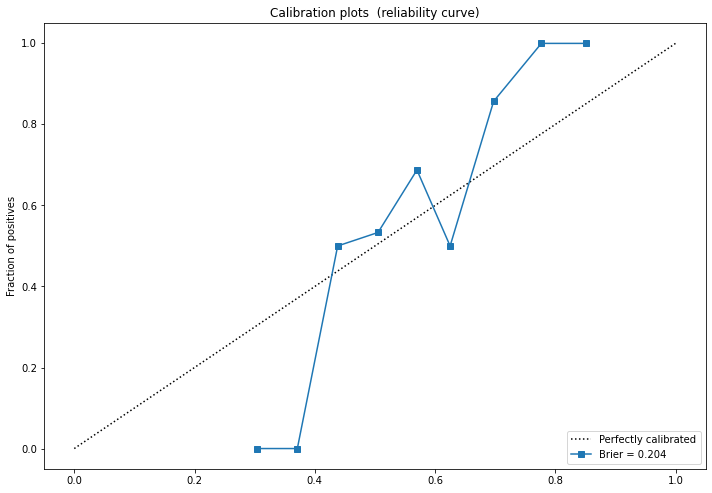

In [18]:
# adapted from: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
y_pred = classifier.predict(test_df[["days_since_previous_release", "weekday"]])
prob_pos = classifier.predict_proba(test_df[["days_since_previous_release", "weekday"]])[:, 1]

clf_score = brier_score_loss(test_df["release_post"], prob_pos, pos_label=1)
print("\tBrier: %1.3f" % (clf_score))

fraction_of_positives, mean_predicted_value = calibration_curve(test_df["release_post"], prob_pos, n_bins=15)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Brier = %1.3f" % (clf_score))

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

plt.tight_layout()

In [19]:
next_30_days = [(df.iloc[-1]["date"] + timedelta(days=i), i, 
                 (df.iloc[-1]["date"] + timedelta(days=i)).weekday()) for i in range(1, 31)]
future_df = pandas.DataFrame(next_30_days, columns=["date", "days_since_previous_release", "weekday"])
future_df["predicted_release"] = classifier.predict([f[1:] for f in next_30_days])
future_df["release_probability"] = [x[1] for x in classifier.predict_proba([f[1:] for f in next_30_days])]

future_df

,date,days_since_previous_release,weekday,predicted_release,release_probability
0,2021-02-07,1,6,False,0.415811
1,2021-02-08,2,0,False,0.314145
2,2021-02-09,3,1,False,0.368602
3,2021-02-10,4,2,False,0.426627
4,2021-02-11,5,3,False,0.486744
5,2021-02-12,6,4,True,0.547248
6,2021-02-13,7,5,True,0.606387
7,2021-02-14,8,6,True,0.662564
8,2021-02-15,9,0,True,0.558216
9,2021-02-16,10,1,True,0.616925
